# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt

from context_data import (
    context_data_load,
    context_data_split
)

import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

### 데이터 셋 읽어오기 / 학습, 검증 데이터 분리

In [7]:
# DATA LOAD
data = context_data_load()

# Train/Valid Split
data = context_data_split(data)

In [8]:
data['train'] # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,...,product_count,timeline_count,idit_all,bant_submit_count,com_reg_count,idx_count,lead_log,lead_count,enterprise_count,enterprise_weight
0,1.00,0,0,0.066667,0,0,0,0.0,0,62.0,...,0,0,0,0,0,0,4.127134,0,0,0
1,1.00,0,0,0.066667,1,0,0,12.0,1,96.0,...,0,0,0,0,0,0,4.564348,0,1,0
2,1.00,1,0,0.088889,2,0,0,144.0,2,56.0,...,0,0,0,0,0,0,4.025352,0,1,0
3,1.00,1,0,0.088889,3,0,0,0.0,3,44.0,...,0,0,0,0,0,1,3.784190,0,0,0
4,1.00,1,0,0.088889,4,1,0,0.0,4,97.0,...,0,0,0,0,0,1,4.574711,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55753,1.00,42,0,0.000000,35096,0,1,0.0,2,200.0,...,0,0,0,0,1,1,5.298317,0,0,0
55754,0.75,9,0,0.040000,35097,1,0,0.0,3,70.0,...,0,0,0,0,1,1,4.248495,0,0,0
55755,0.75,38,0,0.040000,35098,1,0,0.0,2,34.0,...,0,0,0,0,1,1,3.526361,0,0,0
55756,1.00,38,0,0.040000,35099,4,0,0.0,3,377.0,...,0,0,0,0,1,1,5.932245,0,0,0


In [9]:
X, y = data['X_samp'], data['y_samp']
test = data['test'].drop(["is_converted", "id"], axis=1)

In [10]:
X.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'category', 'product_count', 'timeline_count', 'idit_all',
       'bant_submit_count', 'com_reg_count', 'idx_count', 'lead_log',
       'lead_count', 'enterprise_count', 'enterprise_weight'],
      dtype='object')

In [11]:
# RFECV 기준 5000 이상 columns
selected_features = ['customer_idx', 'customer_type', 'lead_owner',
                     'bant_submit', 'historical_existing_cnt', 
                     'response_corporate', 'business_subarea', 
                     'lead_log', 'enterprise_weight', 'customer_country', 
                     'idx_count', 'com_reg_count', 'lead_count', 
                     'product_category', 'com_reg_ver_win_rate', 
                     'lead_desc_length', 'ver_win_rate_x', 
                     'customer_position', 'inquiry_type']

In [12]:
categorical_feature = [feature for feature in data['cat_columns'] if feature in selected_features]

In [13]:
X = X[selected_features]

## 3. 모델 학습

### 모델 정의/학습

### 하이퍼파라미터 튜닝

In [14]:
fold_num = 5
skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(X, y):
    folds.append((train_idx,valid_idx))

In [18]:
for fold in range(0,fold_num):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = X.iloc[train_idx]
    X_valid = X.iloc[valid_idx]
    y_train = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = categorical_feature, free_raw_data=False)
    val_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature = categorical_feature, free_raw_data=False)

    def objective(trial):
        param = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": 0,
            "boosting_type": 'gbdt',
            # "boosting_type": trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
            "n_estimators":trial.suggest_int("n_estimators", 10, 50),
            "max_depth":trial.suggest_int("max_depth", 4, 16),
            # "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            # "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            # "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            # "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 10, 70),
            # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
        }

        # LightGBM 모델 학습
        lgb_model = lgb.train(param, train_data, valid_sets =[val_data], categorical_feature = categorical_feature, callbacks=[lgb.early_stopping(stopping_rounds = 5, verbose = True)])
        preds = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
        pred_labels = np.rint(preds)
        F1 = f1_score(y_valid, pred_labels)
        return F1
    
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name = 'lgbm_parameter_optuna',
        direction = 'maximize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=10)

    print(f"{fold}'s Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    model = lgb.train(study.best_params, train_data, valid_sets =[val_data], categorical_feature = categorical_feature, callbacks=[lgb.early_stopping(stopping_rounds = 5, verbose = True)])
                
    pred = model.predict(test, num_iteration=model.best_iteration)
    data['test'][f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

[I 2024-02-24 15:27:14,340] A new study created in memory with name: lgbm_parameter_optuna


====================================1============================================


c:\Users\hewo1\miniconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
# 각 array의 i번째 값들을 추출하여 리스트 생성
df_test = data['test']
df_test['is_converted'] = df_test['pred_0'] + df_test['pred_1'] + df_test['pred_2'] + df_test['pred_3'] + df_test['pred_4']
df_test['is_converted'] = df_test['is_converted'].apply(lambda x: True if x > 2.5 else False)
test_pred = df_test['is_converted']
print(sum(test_pred))
df_test[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'is_converted']]

In [ ]:
# RFECV를 이용하여 중요도가 낮은 특성을 제거
# cross validation 5번
selector = RFECV(estimator=model, step=1, cv=5, scoring='f1')
selector.fit(x_train, y_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

RFECV(cv=5,
      estimator=LGBMClassifier(bagging_freq=4,
                               feature_fraction=0.6576049662470768,
                               lambda_l1=8.651993713968924e-08,
                               lambda_l2=0.029312295408769517, max_depth=7,
                               min_child_samples=69, n_estimators=920,
                               num_leaves=54),
      scoring='f1')

In [ ]:
selected_features = list(x_train.columns[selector.support_])

In [ ]:
# 선택된 특성들을 사용하여 모델 재학습
model.fit(x_train[selected_features], y_train)

[LightGBM] [Warning] feature_fraction is set=0.6576049662470768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6576049662470768
[LightGBM] [Warning] lambda_l2 is set=0.029312295408769517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029312295408769517
[LightGBM] [Warning] lambda_l1 is set=8.651993713968924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.651993713968924e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6576049662470768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6576049662470768
[LightGBM] [Warning] lambda_l2 is set=0.029312295408769517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029312295408769517
[LightGBM] [Warning] lambda_l1 is set=8.651993713968924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.651993713968924e-08
[LightGBM] [Warning] bagging_f

LGBMClassifier(bagging_freq=4, feature_fraction=0.6576049662470768,
               lambda_l1=8.651993713968924e-08, lambda_l2=0.029312295408769517,
               max_depth=7, min_child_samples=69, n_estimators=920,
               num_leaves=54)

In [ ]:
# 테스트 데이터에 대해 예측
test_pred = model.predict(x_val[selected_features])

[LightGBM] [Warning] feature_fraction is set=0.6576049662470768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6576049662470768
[LightGBM] [Warning] lambda_l2 is set=0.029312295408769517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029312295408769517
[LightGBM] [Warning] lambda_l1 is set=8.651993713968924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.651993713968924e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [ ]:
selected_features = ['customer_idx', 'customer_type', 'lead_owner', 'bant_submit', 'historical_existing_cnt', 'response_corporate', 'business_subarea', 'laed_log', 'enterprise_weight', 'customer_country', 'idx_count', 'com_reg_count', 'lead_count', 'product_category', 'com_reg_ver_win_rate', 'lead_desc_length', 'ver_win_rate_x', 'customer_position', 'inquiry_type']

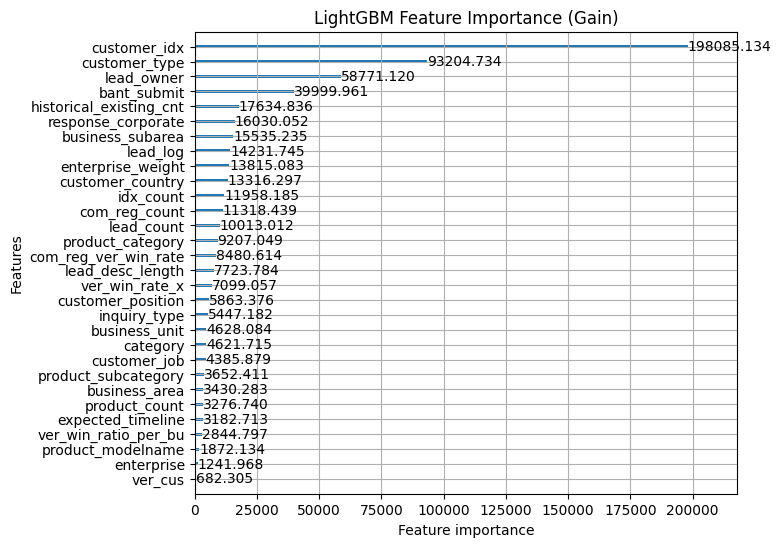

In [ ]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [ ]:
optuna.visualization.plot_param_importances(study)

### 모델 성능 보기

In [ ]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [ ]:
pred = model.predict(x_val[selected_features])
pred = [1 if x >= 0.5 else 0 for x in pred]
get_clf_eval(y_val, pred)

[LightGBM] [Warning] feature_fraction is set=0.6576049662470768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6576049662470768
[LightGBM] [Warning] lambda_l2 is set=0.029312295408769517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029312295408769517
[LightGBM] [Warning] lambda_l1 is set=8.651993713968924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.651993713968924e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
오차행렬:
 [[10126   106]
 [   99 10133]]

정확도: 0.9900
정밀도: 0.9903
재현율: 0.9896
F1: 0.9900


## 4. 제출하기

### 테스트 데이터 예측

In [ ]:
# 예측에 필요한 데이터 분리
x_val = data['test'].drop(["is_converted", "id"], axis=1)
x_val = x_val[selected_features]

In [ ]:
test_pred = model.predict(x_val)

[LightGBM] [Warning] feature_fraction is set=0.6576049662470768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6576049662470768
[LightGBM] [Warning] lambda_l2 is set=0.029312295408769517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029312295408769517
[LightGBM] [Warning] lambda_l1 is set=8.651993713968924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.651993713968924e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [ ]:
test_pred = [1 if x >= 0.5 else 0 for x in test_pred]
sum(test_pred) # True로 예측된 개수

1256

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred
df_sub["is_converted"] = df_sub["is_converted"].astype(bool)

In [ ]:
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**